# Using deep learning to classify Weibull patterns 

## Overview 
Although distribution fitting is easy to do with MLE, the workflow usually assumes there is a human in the loop to validate fits. To scale this up, we need an approach that can take arbitrary sample sizes, engineer features that are relevant to distribution fitting, and then do the fit or classify the category of distribution. Here, we use an autoencoder to get a standard set of features regardless of sample size, then pass the encoded samples to a classifier. 

## Notes
1. Min-max scaling helps deal with sample from Weibulls of different scales and speeds up autoencoder training. We don't particularly care about estimating the scale parameter, so this is fine. 
1. Autoencoder can encode to 30 dimensions. We only work with sample of size 31 and above, so this shouldn't represent more dimensions than data points in a sample. Arguably, distribution fitting boils data down to only 2 or 3 parameters, which is not enough to deal with all the complexity in the case where we can't be sure that data is "nearly Weibull". The autoencoder with 30 dimensions can represent the data more richly. 


## Next steps 
1. Define the classifier NN. Train on the training samples. Quantify performance on the test samples. 
2. How to deal with shape=1? Where do we set the boundaries? 
3. Try changing the autoencoder architecture. Do we need more layers? 
  1. Do we need more layers? 
  1. Add dropout?
  1. Inputs: instead of just the raw sample, add histogram representation(s), and/or ecdf quantiles 
4. Autoencoder training: 
  1. Instead of nn.MSELoss, use a loss function based on KL Divergence, Wasserstein distance, or Anderson-Darling test stat. 
 

In [148]:
import math
import numpy as np
import pandas as pd 
from scipy.stats import weibull_min, norm
from enum import Enum, auto
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from umap import UMAP
import seaborn as sns 
import xgboost as xgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data generation

In [115]:
class DistributionCategory(Enum):
    LESS_THAN_ONE = auto()
    GREATER_THAN_ONE = auto()
    UNIFORM = auto()
    BIMODAL_UNIFORM = auto()
    BIMODAL_STOW = auto()

In [183]:
np.random.seed(42)
num_samples = 8000
max_obs_per_sample = 200  # Values tried: 1000, 200
data_samples = []
labels = []

In [184]:
for _ in range(num_samples):
    n = np.random.randint(31, max_obs_per_sample + 1)
    category = np.random.choice(
        [
            DistributionCategory.LESS_THAN_ONE, 
            DistributionCategory.GREATER_THAN_ONE, 
            DistributionCategory.UNIFORM, 
            DistributionCategory.BIMODAL_UNIFORM, 
            DistributionCategory.BIMODAL_STOW
        ]
    )
    
    if category == DistributionCategory.LESS_THAN_ONE:
        shape = np.random.uniform(0.1, 0.99)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    elif category == DistributionCategory.GREATER_THAN_ONE:
        shape = np.random.uniform(1.01, 5.0)
        scale = np.random.uniform(100, 10000)
        sample = weibull_min.rvs(c=shape, scale=scale, size=n)
        
    elif category == DistributionCategory.UNIFORM: 
        low = np.random.uniform(0, 0)
        high = np.random.uniform(100, 10000)
        sample = np.random.uniform(low, high, size=n)
        
    elif category == DistributionCategory.BIMODAL_UNIFORM: 
        mean1 = np.random.uniform(80, 100)
        mean2 = np.random.uniform(25, 50)
        std1 = np.random.uniform(1, 10)
        std2 = np.random.uniform(1, 10)
        dist1 = norm(loc=mean1, scale=std1)
        dist2 = norm(loc=mean2, scale=std2)
        sample = np.concatenate([dist1.rvs(size=n//2), dist2.rvs(size=n//2)])
        np.random.shuffle(sample)
        
    elif category == DistributionCategory.BIMODAL_STOW: 
        prop_stow = np.random.uniform(0.25, 0.75)
        n_stow = math.ceil(n*prop_stow)
        n_wo = n - n_stow 
        
        scale = np.random.uniform(100, 10000)
        shape_stow = np.random.uniform(0.1, 0.99)
        shape_wo = np.random.uniform(1.01, 5.0)
        
        sample_stow = weibull_min.rvs(c=shape_stow, scale=scale, size=n_stow)
        sample_wo = weibull_min.rvs(c=shape_wo, scale=scale, size=n_wo)
        
        sample = np.concatenate((sample_stow, sample_wo), axis=0)
        
        
    data_samples.append(sample)
    labels.append(category)

In [185]:
pd.Series(labels).value_counts()

DistributionCategory.BIMODAL_UNIFORM     1625
DistributionCategory.UNIFORM             1622
DistributionCategory.GREATER_THAN_ONE    1615
DistributionCategory.BIMODAL_STOW        1592
DistributionCategory.LESS_THAN_ONE       1546
dtype: int64

# Baseline classifiers 
Before doing anything fancy, we'll try training baseline classifiers and see how they do 

In [186]:
data_samples_padded = (
    [np.pad(sample, 
           (0, max_obs_per_sample - len(sample)),
           mode='constant', constant_values=np.nan
           ) 
     for sample in data_samples
    ]  
)
X = np.array(data_samples_padded)

label_codes_multiclass = np.array([label.value for label in labels]) - 1

# Convert to binary with STOW as target
label_codes = np.where(
    (
        label_codes_multiclass==DistributionCategory.LESS_THAN_ONE.value-1) | 
        (label_codes_multiclass==DistributionCategory.BIMODAL_STOW.value-1),
        1, 0
    )  

In [187]:
len(np.unique(label_codes_multiclass))

5

In [188]:
len(np.unique(label_codes))

2

In [189]:
label_codes[:10]

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [190]:
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, label_codes, test_size=0.20, random_state=2023)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.20, random_state=2023)

In [191]:
# X_train_and_valid.shape
X_train.shape
X_valid.shape 
X_test.shape 

y_train.shape
y_valid.shape
y_test.shape

(5120, 200)

(1280, 200)

(1600, 200)

(5120,)

(1280,)

(1600,)

In [192]:
model_dict = {
    0: xgb.XGBClassifier(
        objective="binary:logistic", 
        tree_method='gpu_hist', 
        random_state=11)

}

def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'{model_desc}')
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    plt.plot()
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)





model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=11,
              reg_alpha=None, reg_lambda=None, ...)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       802
           1       0.98      0.92      0.95       478

    accuracy                           0.96      1280
   macro avg       0.96      0.95 

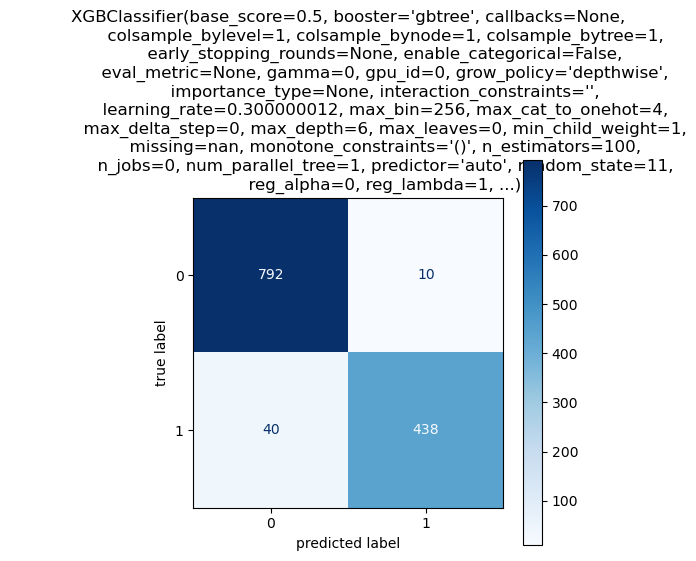

In [193]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)



model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=11,
              reg_alpha=0, reg_lambda=1, ...)
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       970
           1       0.97      0.91      0.94       630

    accuracy                           0.95      1600
   macro avg       0.96      0.95      0.95      1600
weighted avg       0

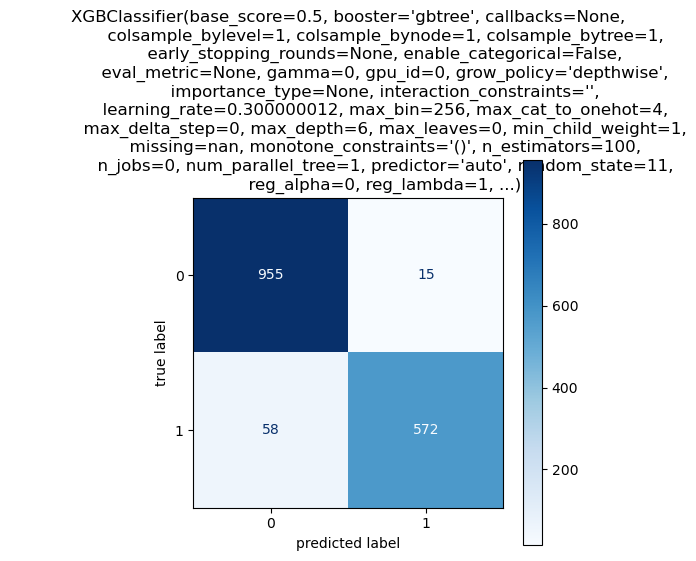

In [194]:
# Retrain on train and val data, then run on test
selected_model_num = 0
train_eval_pipeline(selected_model_num, _X_train=X_train_and_valid, _y_train=y_train_and_valid, _X_valid=X_test, _y_valid=y_test)

# End/Baseline classifiers
****

In [195]:
# min-max scaling and padding the data: 
data_samples_min_max_scaled = [(sample - sample.min()) / (sample.max() - sample.min()) for sample in data_samples]

samples_padded_with_nans = False 
if samples_padded_with_nans: 
    data_samples_preprocessed = (
        [np.pad(sample, 
               (0, max_obs_per_sample - len(sample)), 
               mode='constant', constant_values=np.nan) 
         for sample in data_samples_min_max_scaled]  
    )
else: 
    data_samples_preprocessed = (
        [np.pad(sample, (0, max_obs_per_sample - len(sample))) for sample in data_samples_min_max_scaled]  
    )

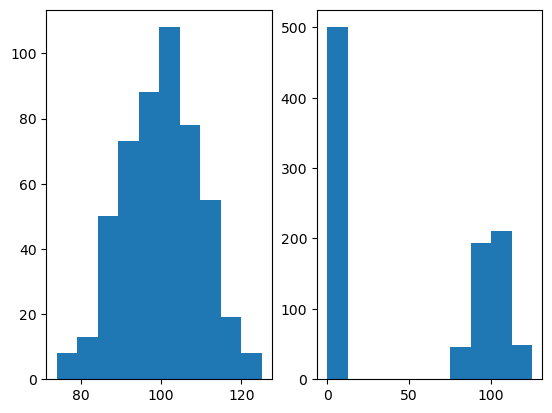

In [196]:
# Hypothesis: Padding with zeroes can distort the distribution 
# True 

sample = norm(loc=100, scale=10).rvs(size=500)
sample_padded = np.pad(sample, (0, 1000-len(sample)))

fig, ax = plt.subplots(1,2)
ax[0].hist(sample);
ax[1].hist(sample_padded)
fig.show();


In [197]:
labels = pd.Series(labels)

In [198]:
labels.head()

0     DistributionCategory.BIMODAL_UNIFORM
1    DistributionCategory.GREATER_THAN_ONE
2       DistributionCategory.LESS_THAN_ONE
3             DistributionCategory.UNIFORM
4       DistributionCategory.LESS_THAN_ONE
dtype: object

In [199]:
labels.value_counts()

DistributionCategory.BIMODAL_UNIFORM     1625
DistributionCategory.UNIFORM             1622
DistributionCategory.GREATER_THAN_ONE    1615
DistributionCategory.BIMODAL_STOW        1592
DistributionCategory.LESS_THAN_ONE       1546
dtype: int64

4951


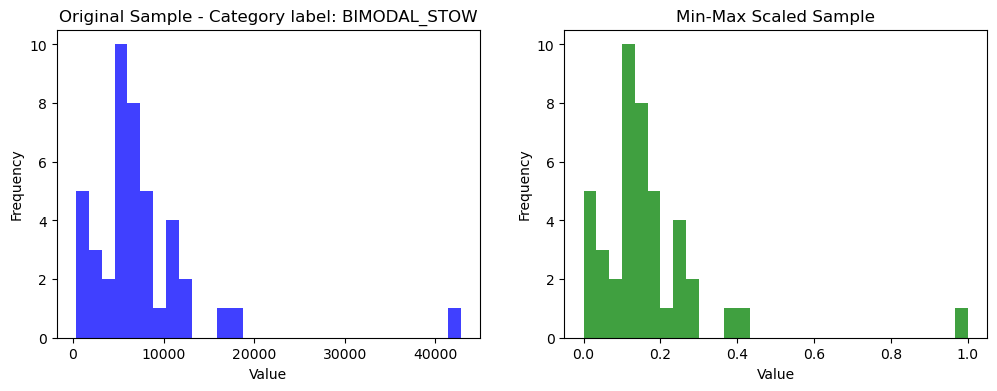

In [200]:
# Select a single sample from the data_samples list
np.random.seed(2023)
sample_index = np.random.randint(len(labels) + 1, size=1).tolist()[0]
print(sample_index)

sample = data_samples[sample_index]
label = labels[sample_index]

# Apply min-max scaling to the selected sample
sample_min_max_scaled = data_samples_min_max_scaled[sample_index]

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(sample, bins=30, alpha=0.75, color='blue')
ax1.set_title(f'Original Sample - Category label: {label.name}')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')

ax2.hist(sample_min_max_scaled, bins=30, alpha=0.75, color='green')
ax2.set_title('Min-Max Scaled Sample')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

plt.show();


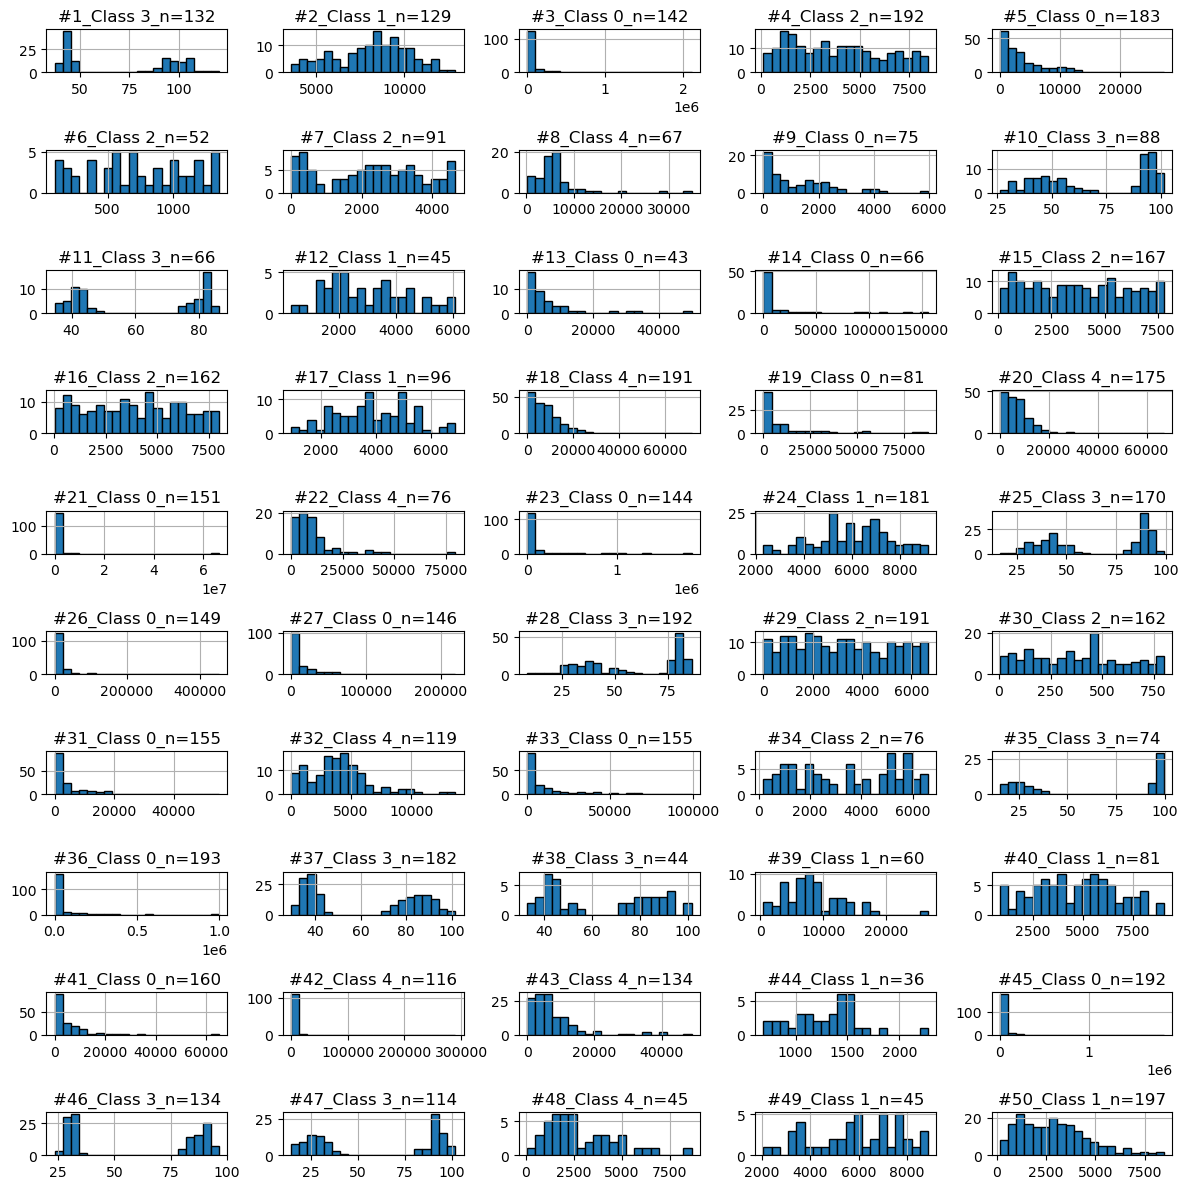

In [201]:
# Plot the first 50 samples 
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = data_samples[sample_index]
    label = labels[sample_index].value - 1 
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'#{sample_index+1}_Class {label}_n={len(selected_sample)}')
    ax.grid(True)

plt.tight_layout()
plt.show();


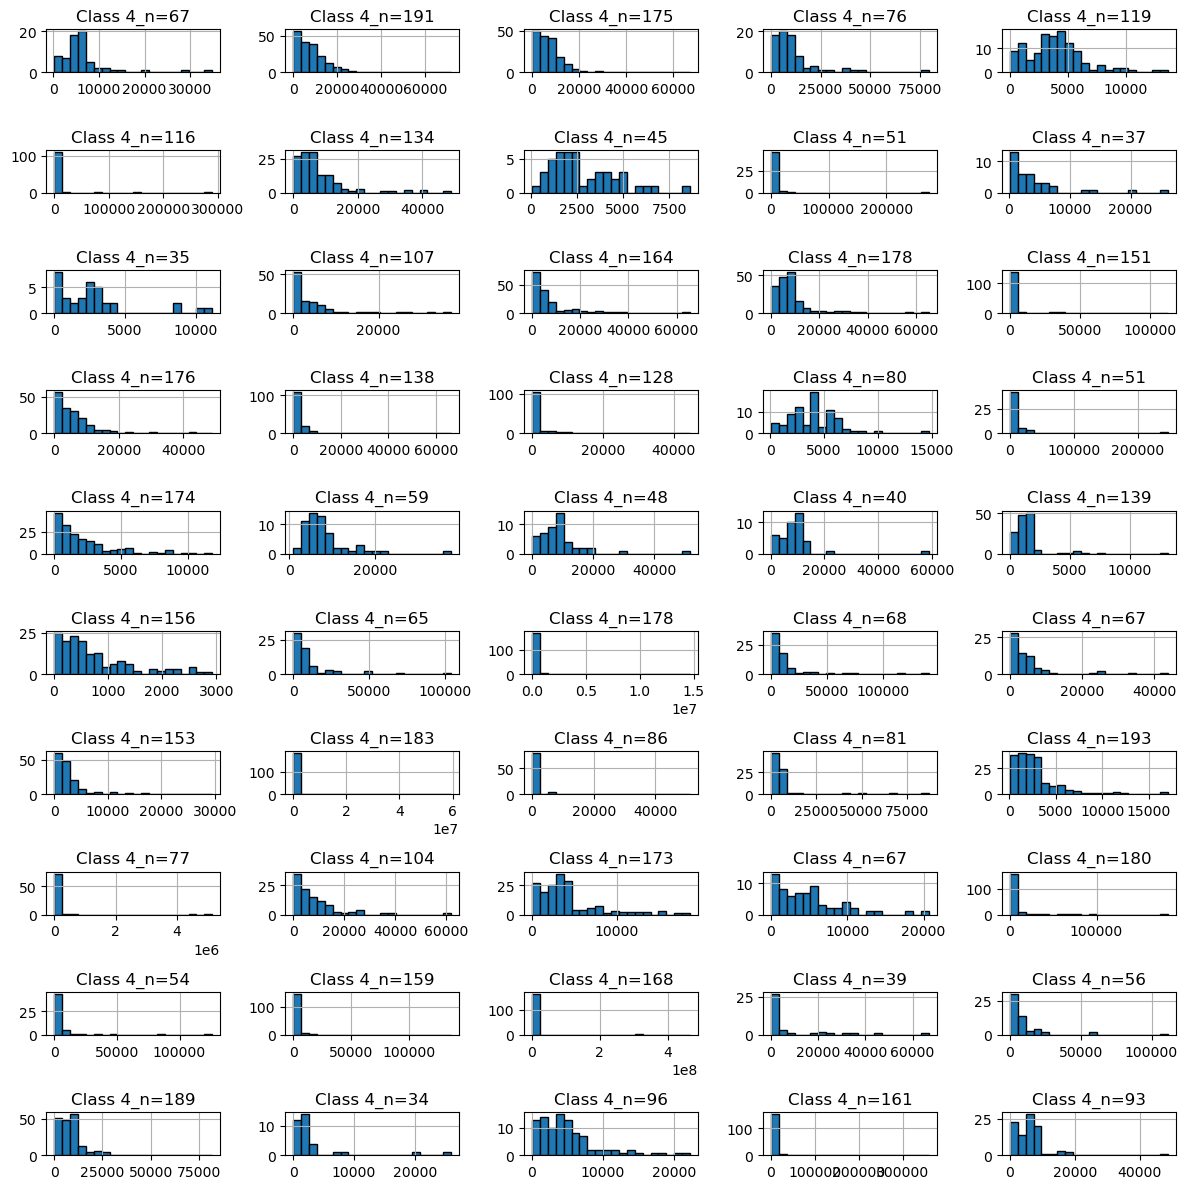

In [216]:
# Plot first 50 bimodal_wearouts 
nrow = 10
ncol = 5
fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
ax_flat = axes.flatten()

indices = np.where(label_codes_multiclass==4)[0]
data_samples_bimodal_stow = [data_samples[i] for i in indices]

for ax, sample_index in zip(ax_flat, list(range(nrow*ncol))): 
    selected_sample = data_samples_bimodal_stow[sample_index]
    ax.hist(selected_sample, bins=20, edgecolor='black')
    ax.set_title(f'Class 4_n={len(selected_sample)}')
    ax.grid(True)

plt.tight_layout()
plt.show();

In [212]:
filter = np.where(label_codes_multiclass==4)
filter

(array([   7,   17,   19, ..., 7992, 7996, 7998]),)

In [211]:
label_codes_multiclass

array([3, 1, 0, ..., 3, 4, 2])

## Train/test split 

In [ ]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(data_samples_preprocessed, labels, test_size=0.2, random_state=42)

# Example a randomly selected sample: 
sample_idx = np.random.randint(len(X_train_and_val))
assert type(X_train_and_val) == list 
assert type(X_train_and_val[sample_idx]) == np.ndarray
assert X_train_and_val[sample_idx].shape == (max_obs_per_sample,)  # this is due to padding

## Autoencoder architecture

In [ ]:
input_size = max_obs_per_sample
embedding_size = 30

class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_size, embedding_size)

In [ ]:
autoencoder

## Autoencoder training 

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2, random_state=42)

# Convert Enum labels to integers
y_train_int = np.array([label.value for label in y_train]) - 1
y_val_int = np.array([label.value for label in y_val]) - 1

# Convert data to PyTorch tensors
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

assert X_train_tensor.shape == (len(X_train), max_obs_per_sample)
X_train_tensor.shape
y_train_tensor.shape

In [ ]:
if samples_padded_with_nans: 
    print("Can't train an AE")
else: 
    # Training parameters
    epochs = 300
    batch_size = 256
    learning_rate = 0.001
    patience = 10 

    autoencoder = Autoencoder(input_size, embedding_size).to(device);

    # Set loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # Train the autoencoder
    autoencoder.train();
    for epoch in range(epochs):
        for batch_idx in range(0, len(X_train_tensor), batch_size):
            batch = X_train_tensor[batch_idx:batch_idx+batch_size, :].to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()

        # Calculate validation loss
        autoencoder.eval();
        val_outputs = autoencoder(X_val_tensor.to(device))
        val_loss = criterion(val_outputs.to(device), X_val_tensor.to(device))

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Print progress
        if (epoch + 1) % 10 == 0 or epochs_without_improvement == 1:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Stop training if no improvement for 'patience' epochs
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            break

## Autoencoder inference on training data

In [ ]:
if autoencoder.training: 
    autoencoder.eval()
    
with torch.no_grad(): 
    ae_out = autoencoder.encoder(X_train_tensor.to(device))
    ae_out_valid = autoencoder.encoder(X_val_tensor.to(device))

In [ ]:
ae_out.shape

In [ ]:
ae_out_valid.shape

### Visualizing the AE ouputs in 2D
This can be helpful in understanding whether a classifier will be able to distinguish the classes

In [ ]:
mapper = UMAP(n_components=2, metric='cosine', random_state=2023).fit(ae_out.cpu())

df_umap_2d = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_umap_2d['label'] = [enum.name for enum in y_train]
df_umap_2d

In [ ]:
sns.scatterplot(data=df_umap_2d, x='X', y='Y', hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.hexbin(
    df_umap_2d['X'],
    df_umap_2d['Y'],
    cmap="Greys", 
    gridsize=20
)
fig.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(9,9), sharex=True, sharey=True)
axes = axes.flatten()
labels = df_umap_2d['label'].unique()
cmap = "Greys"

for i, label in enumerate(labels): 
    df_umap_sub = df_umap_2d.query('label==@label')
    axes[i].hexbin(
        df_umap_sub['X'], 
        df_umap_sub['Y'], 
        cmap=cmap, 
        gridsize=20
    )
    axes[i].set_title(label)
plt.tight_layout()
plt.show()


In [ ]:
model_dict = {
    0: xgb.XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', random_state=11)
}

for model in model_dict.keys(): 
    train_eval_pipeline(model, X_train=ae_out, y_train=y_train, X_valid=ae_out_valid, y_valid=y_val_tensor)